In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

In [9]:
molecule = 7294

mux = np.loadtxt(f'../reduced_molecules/{molecule}/mux.dat')
muy = np.loadtxt(f'../reduced_molecules/{molecule}/muy.dat')
muz = np.loadtxt(f'../reduced_molecules/{molecule}/muz.dat')

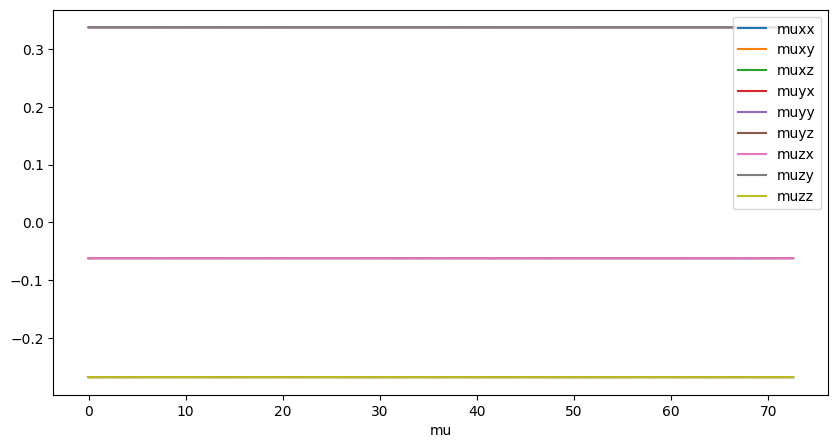

In [10]:
plt.figure(figsize=(10,5))
plt.plot(mux[:,0], mux[:,1])
plt.plot(mux[:,0], mux[:,2])
plt.plot(mux[:,0], mux[:,3])
plt.plot(muy[:,0], muy[:,1])
plt.plot(muy[:,0], muy[:,2])
plt.plot(muy[:,0], muy[:,3])
plt.plot(muz[:,0], muz[:,1])
plt.plot(muz[:,0], muz[:,2])
plt.plot(muz[:,0], muz[:,3])
plt.xlabel('fs')
plt.xlabel('mu')
plt.legend(['muxx', 'muxy', 'muxz', 'muyx', 'muyy', 'muyz', 'muzx', 'muzy', 'muzz'])
plt.show()

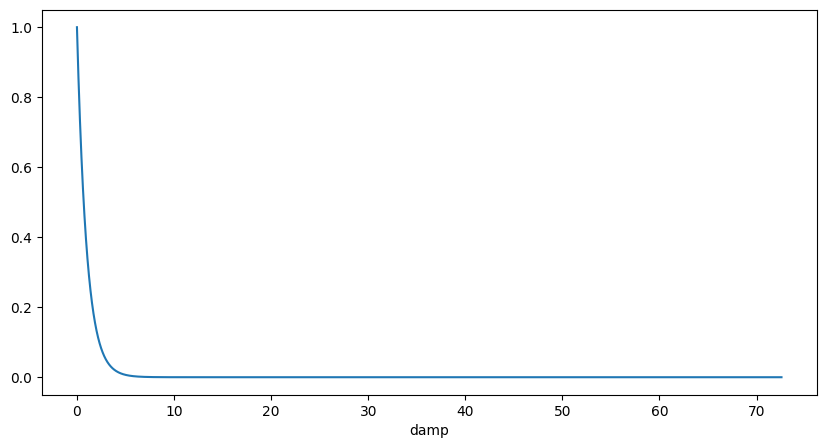

In [ ]:
tau = 200.0
damp = np.exp(-mux[:,0]/ tau)

plt.figure(figsize=(10,5))
plt.plot(mux[:,0], damp)
plt.xlabel('fs')
plt.xlabel('damp')
plt.show()

In [12]:
average = ((mux[:,1]-mux[0,1]) + (muy[:,2]-muy[0,2]) + (muz[:,3]-muz[0,3]))/3.0
E0 = 0.001

spec = np.fft.rfft(damp * average, 10 * mux.shape[0])
frec = np.fft.rfftfreq(10*mux.shape[0], (mux[1,0] - mux[0,0]) * 1.0E-15)
energsnm = constants.nu2lambda(frec[1:]) * 1.0E9

alpha = spec / E0

hplanck = constants.physical_constants['Planck constant in eV s'][0] * 1.0E15
cspeednm = constants.speed_of_light * 1.0e9 / 1.0e15
emin = 0.5
emax = 30.
wvlmin = hplanck * cspeednm / emax
wvlmax = hplanck * cspeednm / emin

np.savetxt(f'alpha_nm_{molecule}.dat',np.column_stack((energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)], \
                                            alpha[1:][(energsnm>wvlmin)&(energsnm<wvlmax)])))

In [13]:
import numpy as np
from scipy import constants

damp = np.exp(-mux[:,0] / tau)
# Convert dipole moment from e·Å to e·bohr (1 Å = 1 / 0.529177249 bohr)
eA_to_ebohr = 1 / 0.529177249  # ≈ 1.889725989
average = ((mux[:,1] * eA_to_ebohr - mux[0,1] * eA_to_ebohr) + 
            (muy[:,2] * eA_to_ebohr - muy[0,2] * eA_to_ebohr) + 
            (muz[:,3] * eA_to_ebohr - muz[0,3] * eA_to_ebohr)) / 3.0

# Fourier transform of the damped dipole response
spec = np.fft.rfft(damp * average, 10 * mux.shape[0])

# Compute linear frequency (Hz) and angular frequency (rad/s)
time_step = (mux[1,0] - mux[0,0]) * 1.0e-15  # Time step in seconds (mux[:,0] in fs)
freq = np.fft.rfftfreq(10 * mux.shape[0], time_step)  # Linear frequency in Hz
omega = 2 * np.pi * freq  # Angular frequency in rad/s

# Compute wavelength in nm: lambda = c / f = 2 * pi * c / omega
c = constants.speed_of_light  # Speed of light in m/s
wavelength = c / (freq + 1e-10) * 1.0e9  # Wavelength in nm, avoid div by zero
wavelength[0] = np.inf  # Set DC component to infinity

# Convert field from V/Å to atomic units (hartree/(e·bohr))
field_au = E0 / 5.142206747  # 1 V/Å ≈ 1 / 5.142206747 au

# Compute polarizability: alpha(omega) = spec / field
# spec is in e·bohr, field_au is in hartree/(e·bohr), alpha is in bohr³
alpha = spec / field_au

# Energy range (0.5 eV to 30 eV) converted to omega and wavelength
hplanck = constants.physical_constants['Planck constant in eV s'][0]  # ≈ 4.135667696e-15 eV·s
emin = 0.5  # eV
emax = 30.0  # eV
omega_min = emin / hplanck * 2 * np.pi  # rad/s
omega_max = emax / hplanck * 2 * np.pi  # rad/s
wvl_max = c / (omega_min / (2 * np.pi)) * 1.0e9  # nm
wvl_min = c / (omega_max / (2 * np.pi)) * 1.0e9  # nm

# Masks for omega and wavelength ranges
mask_omega = (omega > omega_min) & (omega < omega_max)
mask_wvl = (wavelength > wvl_min) & (wavelength < wvl_max)

# Debug: Print mask and ranges
print("omega_min:", omega_min, "omega_max:", omega_max)
print("omega range:", omega.min(), "to", omega.max())
print("mask_omega sum:", mask_omega.sum(), "of", len(mask_omega))
print("wvl_min:", wvl_min, "wvl_max:", wvl_max)
print("wavelength range:", wavelength[~np.isinf(wavelength)].min(), "to", wavelength[~np.isinf(wavelength)].max())

# # Save polarizability vs. omega
# np.savetxt('polarizability-omega.dat', np.column_stack((
#     omega[mask_omega],
#     alpha.real[mask_omega],
#     alpha.imag[mask_omega]
# )), header='Omega(rad/s) Re[alpha](bohr^3) Im[alpha](bohr^3)', fmt='%.6e')

# # Save polarizability vs. wavelength (sorted ascending)
indices = np.argsort(wavelength[mask_wvl])
# np.savetxt('polarizability-nm.dat', np.column_stack((
#     wavelength[mask_wvl][indices],
#     alpha.real[mask_wvl][indices],
#     alpha.imag[mask_wvl][indices]
# )), header='Wavelength(nm) Re[alpha](bohr^3) Im[alpha](bohr^3)', fmt='%.6e')

omega_min: 759633730354079.1 omega_max: 4.557802382124475e+16
omega range: 0.0 to 1.2987775476345413e+18
mask_omega sum: 5177 of 150006
wvl_min: 41.3280657954031 wvl_max: 2479.6839477241865
wavelength range: 1.450326555721217 to 217556.23499096118


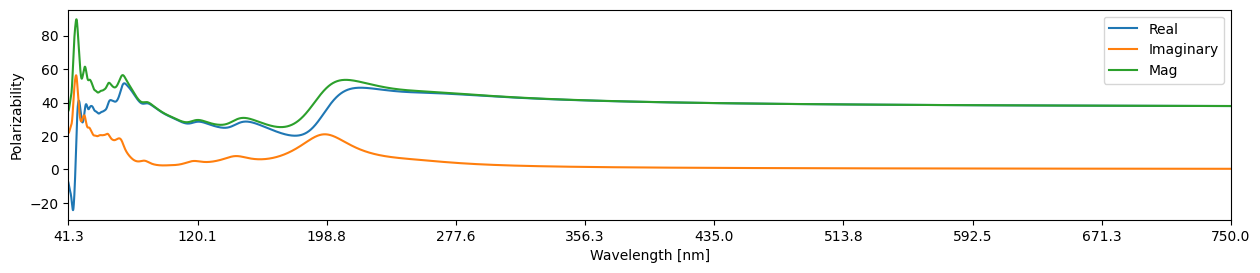

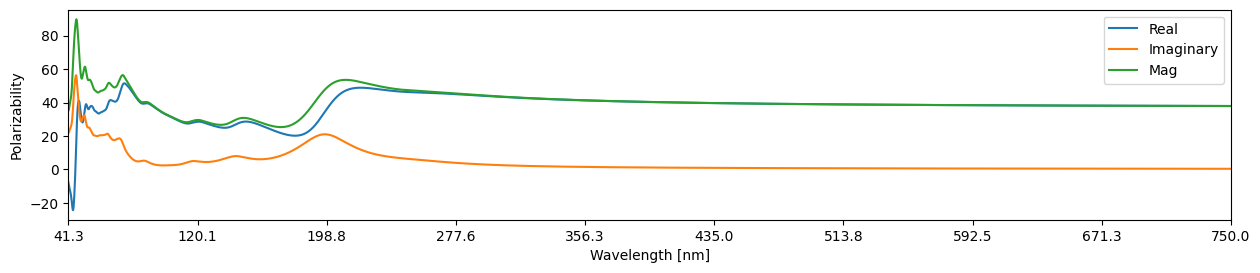

In [14]:
# plt.figure(figsize=(15,7))
# plt.subplot(3,1,1)
# plt.plot(omega[mask_omega], alpha.real[mask_omega])
# plt.plot(omega[mask_omega], -2*alpha.imag[mask_omega]/np.pi)
# plt.plot(omega[mask_omega], np.abs(alpha[mask_omega]))
# plt.legend(['Real', 'Imaginary', 'Mag'])
# plt.xlabel('frequency [rad/s]')
# plt.show()

plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(wavelength[mask_wvl][indices], alpha.real[mask_wvl][indices])
plt.plot(wavelength[mask_wvl][indices], -2*alpha.imag[mask_wvl][indices]/np.pi)
plt.plot(wavelength[mask_wvl][indices], np.abs(alpha[mask_wvl][indices]))
plt.legend(['Real', 'Imaginary', 'Mag'])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Polarizability')
plt.xlim([energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)].min(), 750])
plt.xticks(np.linspace(energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)].min(), 750, 10))
plt.show()

plt.figure(figsize=(15,6))
plt.subplot(2,1,2)
plt.plot(energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)], alpha.real[1:][(energsnm>wvlmin)&(energsnm<wvlmax)])
plt.plot(energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)], -2*alpha.imag[1:][(energsnm>wvlmin)&(energsnm<wvlmax)]/np.pi)
plt.plot(energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)], np.abs(alpha[1:][(energsnm>wvlmin)&(energsnm<wvlmax)]))
plt.legend(['Real', 'Imaginary', 'Mag'])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Polarizability')
plt.xlim([energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)].min(), 750])
plt.xticks(np.linspace(energsnm[(energsnm>wvlmin)&(energsnm<wvlmax)].min(), 750, 10))
plt.show()